<a href="https://colab.research.google.com/github/LugoBlogger/MLCC-Assignment-05/blob/arul%2Fmodelling/medical_cost_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we will predict health insurance cost that someone should pay annually by the given features.
For the complete introduction, see the slides.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
# Use tensorflow 2
%tensorflow_version 2.x

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc1


In [0]:
### this library is for callback functions
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Medical Cost Personal Datasets

## Retrieve the dataset

Manage the dataset into pandas' DataFrame.

In [100]:
dataset = pd.read_csv("https://raw.githubusercontent.com/LugoBlogger/MLCC-Assignment-05/master/datasets/insurance.csv", header=0)
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Clean the data

Checking the dataset whether its contains some undefined measurement or not.

In [101]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Convert categorical columns into numeric with the following convention:

* `sex`: male = 1, female = 2,

* `smoker`: yes = 1, no = 0,

* `region`: northeast = $\displaystyle\frac{\pi}{4}$, northwest = $\displaystyle\frac{3\pi}{4}$, southwest = $\displaystyle\frac{5\pi}{4}$, southeast = $\displaystyle\frac{7\pi}{4}$. We use the representation of direction by their angle on unit circle. If we compute the method `.mean`, it will make a sense (where is the region whose citizens are the most recorded).

In [102]:
dataset.loc[dataset['sex'] == 'male', 'sex'] = 1
dataset.loc[dataset['sex'] == 'female', 'sex'] = 2

dataset.loc[dataset['smoker'] == 'yes', 'smoker'] = 1
dataset.loc[dataset['smoker'] == 'no', 'smoker'] = 0

dataset.loc[dataset['region'] == 'northeast', 'region'] = np.pi/4
dataset.loc[dataset['region'] == 'northwest', 'region'] = 3*np.pi/4
dataset.loc[dataset['region'] == 'southwest', 'region'] = 5*np.pi/4
dataset.loc[dataset['region'] == 'southeast', 'region'] = 7*np.pi/4

dataset['region'] = pd.to_numeric(dataset['region'])

dataset

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,3.926991,16884.92400
1,18,1,33.770,1,0,5.497787,1725.55230
2,28,1,33.000,3,0,5.497787,4449.46200
3,33,1,22.705,0,0,2.356194,21984.47061
4,32,1,28.880,0,0,2.356194,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2.356194,10600.54830
1334,18,2,31.920,0,0,0.785398,2205.98080
1335,18,2,36.850,0,0,5.497787,1629.83350
1336,21,2,25.800,0,0,3.926991,2007.94500


In [103]:
target = dataset['charges']
features = dataset.drop(columns='charges')

features.head()

,age,sex,bmi,children,smoker,region
0,19,2,27.900,0,1,3.926991
1,18,1,33.770,1,0,5.497787
2,28,1,33.000,3,0,5.497787
3,33,1,22.705,0,0,2.356194
4,32,1,28.880,0,0,2.356194


## Split the data into a training set and a test set.

In [0]:
class SortedStratifiedKFold:
    
    """
    This is a class for split data into a few groups, which is each group has same distribution.
    Usually this method regarded as Stratified K Fold Cross Validation. But I create another one
    for continuous data at target's dataset with Sorted Stratified K Fold method. This method inspired
    by article (https://scottclowe.com/2016-03-19-stratified-regression-partitions/).
    
    This method is useful to make sure validation and test performance gives depicts 
    the expected performance of the model with less bias and variance.
    """
    
    def __init__(self, n_splits):
        self._n_splits = n_splits
    
    def split(self, X, y):
        x = X.copy()
        
        # sorted target values
        self._sorted_idx = y.sort_values().index
        
        self._groups = [list() for _ in range(self._n_splits)]
        it = int(np.ceil(x.shape[0] / self._n_splits))
        
        for i in range(it):
            c = i * self._n_splits
            
            if (len(y) % self._n_splits != 0) and i==(it-1):
                rand_idx = np.random.permutation(range(len(y) % self._n_splits)) + c
                
                for j in range(len(rand_idx)):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                
            else:
                rand_idx = np.random.permutation(range(self._n_splits)) + c
                
                for j in range(self._n_splits):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                    
                  
        return [(x.iloc[list(set(y.index) - set(idx))], y.iloc[list(set(y.index) - set(idx))], 
                                 x.iloc[idx], y.iloc[idx]) for idx in self._groups]

We divided the dataset into 5 groups to get 20% of data for test set

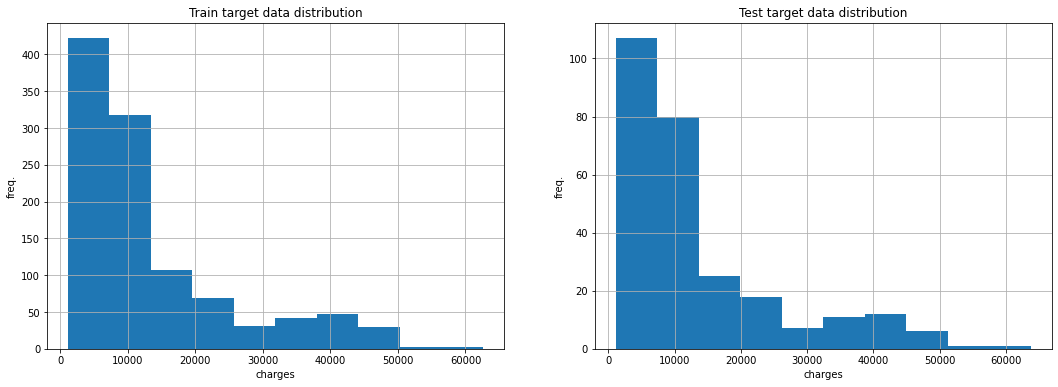

In [105]:
n_splits = 5

ssfk = SortedStratifiedKFold(n_splits=n_splits)

train_test_split = ssfk.split(features, target)
train_features, train_target, test_features, test_target = train_test_split[0]

plt.figure(figsize=(18,6))
plt.subplot(121)
train_target.hist().set_title('Train target data distribution')
plt.xlabel('charges')
plt.ylabel('freq.')

plt.subplot(122)
test_target.hist().set_title('Test target data distribution')
plt.xlabel('charges')
plt.ylabel('freq.');

In [106]:
test_target

1244     1135.94070
194      1137.46970
487      1253.93600
513      1256.29900
478      1534.30450
           ...     
94      47291.05500
328     47928.03000
901     48673.55880
1146    52590.82939
543     63770.42801
Name: charges, Length: 268, dtype: float64

## Inspect the data

We look at the joint distribution of a few pairs of columns from the training set. The diagonal elements represent kernel density estimation (kde) for univariate variables for given columns. We include all the columns to inspect which variable has a correlation to another variable

In [107]:
train_dataset = train_features.copy()
train_dataset[train_target.name] = train_target.copy()
train_dataset.head()

,age,sex,bmi,children,smoker,region,charges
1,18,1,33.77,1,0,5.497787,1725.5523
2,28,1,33.00,3,0,5.497787,4449.4620
4,32,1,28.88,0,0,2.356194,3866.8552
5,31,2,25.74,0,0,5.497787,3756.6216
7,37,2,27.74,3,0,2.356194,7281.5056


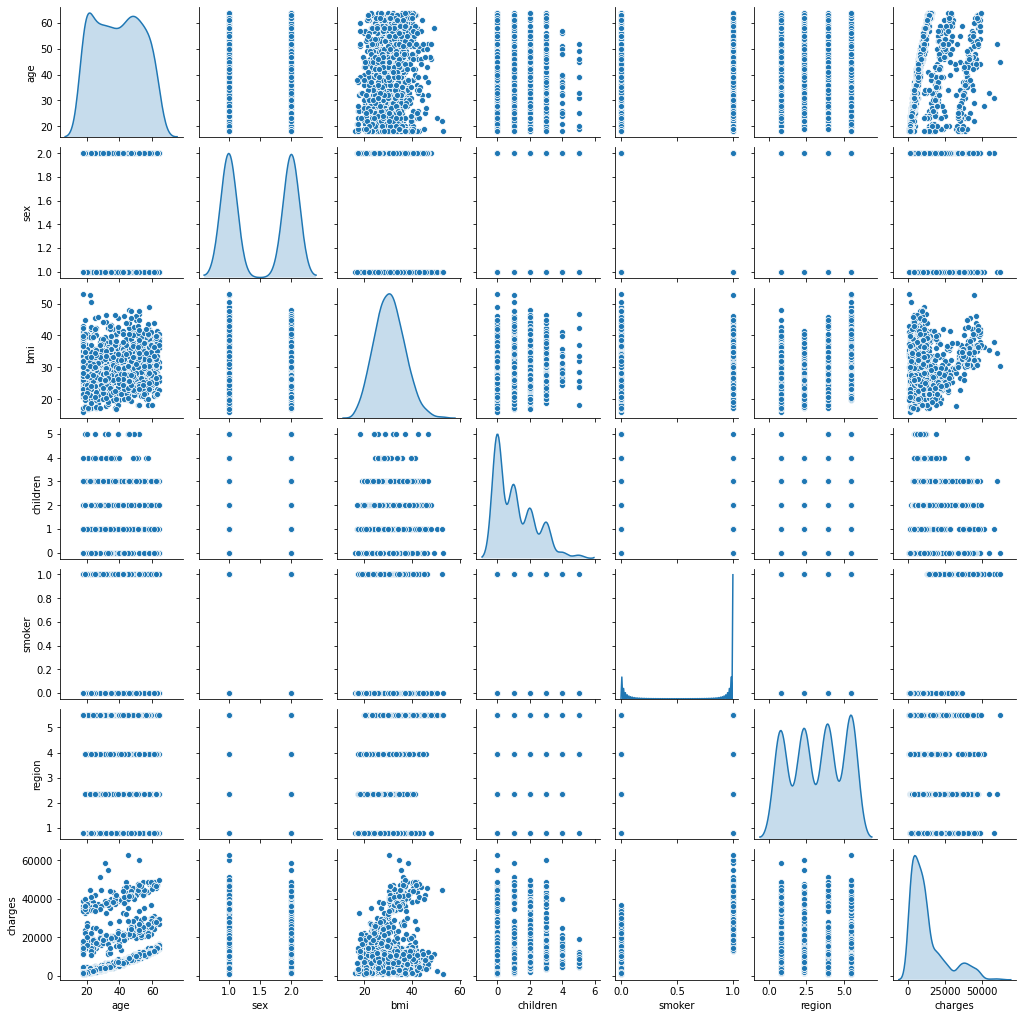

In [108]:
sns.pairplot(train_dataset[['age', 'sex', 'bmi', 'children', 'smoker', 
                            'region', 'charges']], 
             diag_kind='kde', height=2);

If we look at the above table, we can easily notice how categorical and numerical data behave. For continous ones, they are correlated like many clusters, but for the discrete ones, they grouped and distributed by their categories.

We also inspect at their statistical description:

In [109]:
train_stats = train_dataset.describe()
train_stats.pop('charges')

# for pretty output
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.227103,13.937916,18.000000,27.000000,39.000000,51.000000,64.000000
sex,1070.0,1.498131,0.500230,1.000000,1.000000,1.000000,2.000000,2.000000
bmi,1070.0,30.672664,6.150087,15.960000,26.336250,30.495000,34.693750,53.130000
children,1070.0,1.098131,1.202078,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1070.0,0.202804,0.402276,0.000000,0.000000,0.000000,0.000000,1.000000
region,1070.0,3.228207,1.766684,0.785398,2.356194,3.926991,5.497787,5.497787


## Normalize the data

In [0]:
def normalize(x_val):
    return (x_val - train_stats['mean']) / train_stats['std']

normed_train_features = normalize(train_features)
normed_test_features = normalize(test_features)

In [111]:
normed_train_features.head()

,age,sex,bmi,children,smoker,region
1,-1.522975,-0.995803,0.503625,-0.081634,-0.504141,1.284655
2,-0.805508,-0.995803,0.378423,1.582151,-0.504141,1.284655
4,-0.518521,-0.995803,-0.291486,-0.913527,-0.504141,-0.493587
5,-0.590268,1.003276,-0.802048,-0.913527,-0.504141,1.284655
7,-0.159787,1.003276,-0.476849,1.582151,-0.504141,-0.493587


# Modelling Data

## Construct the model
In this model we use the multilayer perceptron model with two densely connected hidden layars (`layer.Dense(64)`), and an output layer that returns a single continuous value (`layer.Dense(1)`).


In [0]:
def multilayer_perceptron(num_features, learning_rate, optimizers, regularizer_rate=0, dropout_rate=0):
    
    num_perceptron=64
    
    # set optimizers
    if optimizers=='adam':
        opt = tf.keras.optimizers.Adam(lr=learning_rate)
    elif optimizers=='rmsprop':
        opt = tf.keras.optimizers.RMSprop(lr=learning_rate)
    elif optimizers=='sgd':
        opt = tf.keras.optimizers.SGD(lr=learning_rate)
    
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_perceptron, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(regularizer_rate), 
                                    input_shape=(num_features,)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=num_perceptron, 
                                    kernel_regularizer=tf.keras.regularizers.l2(regularizer_rate), 
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    
        
    model.compile(optimizer=opt, loss='mae', 
                  metrics=['mae', 'mse'])
    
    return model
    
    
def train_model(model, features, target, epoch):
    
    history = model.fit(x=features, y=target, epochs=epoch, verbose=0)
    
    hist = pd.DataFrame(history.history)
    
    return model, hist

## Hypertuning Parameter

### Optimizer with different learning rate

In [0]:
normed_train_features = normed_train_features.reset_index()[features.columns]
train_target = train_target.reset_index()['charges']

ssfk = SortedStratifiedKFold(n_splits=n_splits)

# train_val_split contains for elements of tuples 
# (train_feature, train_target, test_feature, test_target) because we use 
# n_splits = 5

train_val_split = ssfk.split(normed_train_features, train_target)

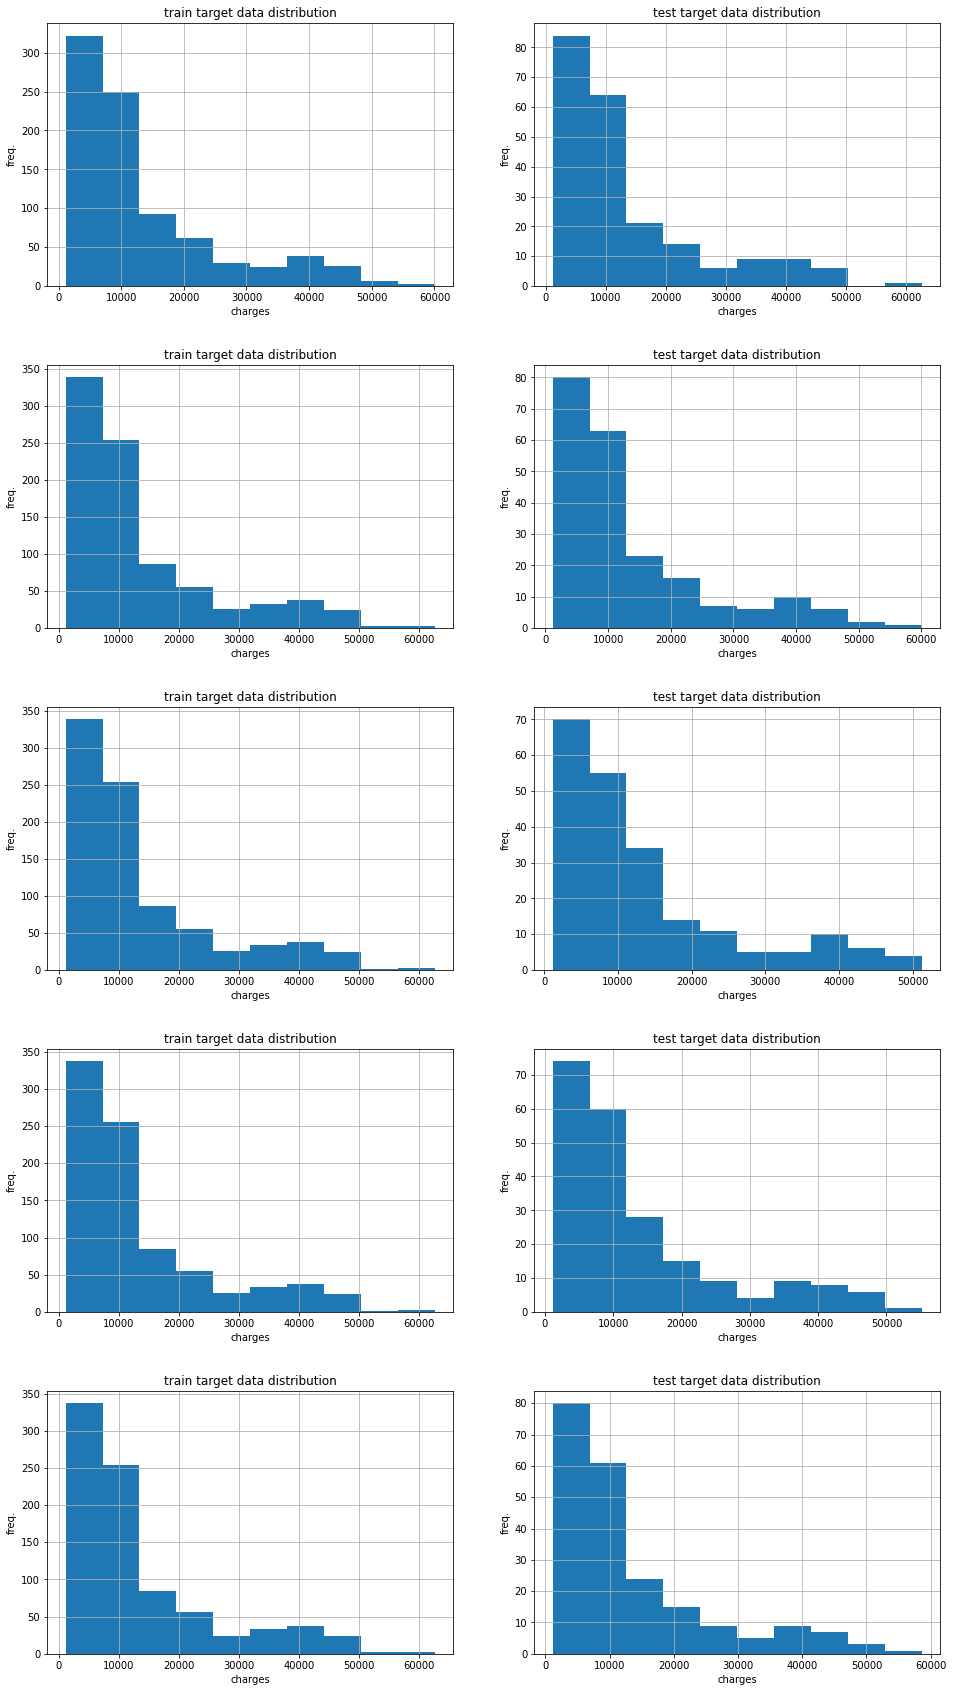

In [114]:
plt.figure(figsize=(16, 30))
for i, (train_feature, train_target, test_feature, test_target) in enumerate(train_val_split):
    plt.subplot(5, 2, 2*i + 1)
    train_target.hist().set_title("train target data distribution")
    plt.xlabel('charges')
    plt.ylabel('freq.')
    
    plt.subplot(5, 2, 2*(i+1))
    test_target.hist().set_title("test target data distribution")
    plt.xlabel('charges')
    plt.ylabel('freq.')

plt.subplots_adjust(hspace=0.3)

In [115]:
train_target.shape

(856,)

In [116]:
learning_rates_list = [.001, .0025, .005, .0075, .01, .025, .05, .075, .1]
result_report = pd.DataFrame({'Learning Rate': learning_rates_list})
result_report

,Learning Rate
0,0.0010
1,0.0025
2,0.0050
3,0.0075
4,0.0100
5,0.0250
6,0.0500
7,0.0750
8,0.1000


In [117]:
start_compute = time.time()

#N_epoch = 4000
N_epoch = 40

for i, (train_features, train_target, 
        validation_features, validation_target) in enumerate(train_val_split):

    print('n_split:', i+1)

    adam_mae, rmsprop_mae, sgd_mae = [], [], []
    print('    Adam training process...')
    for lr in learning_rates_list:
        mlp = multilayer_perceptron(train_features.shape[1], lr, 'adam')
        model, history = train_model(mlp, train_features, train_target, N_epoch)
        loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
        adam_mae.append(mae)

    print('    RMSprop training process...')
    for lr in learning_rates_list:
        mlp = multilayer_perceptron(train_features.shape[1], lr, 'rmsprop')
        model, history = train_model(mlp, train_features, train_target, N_epoch)
        loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
        rmsprop_mae.append(mae)

    print('    SGD training process...')
    for lr in learning_rates_list:
        mlp = multilayer_perceptron(train_features.shape[1], lr, 'sgd')
        model, history = train_model(mlp, train_features, train_target, N_epoch)
        loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
        sgd_mae.append(mae)

    result_report['Adam-'+str(i+1)] = adam_mae
    result_report['RMSprop-'+str(i+1)] = rmsprop_mae
    result_report['SGD-'+str(i+1)] = sgd_mae

print("Approximation computational time: {:.2f}".format(time.time() - start_compute))

n_split: 1
    Adam training process...
7/7 [==============================] - 0s 2ms/step - loss: 2522.6838 - mae: 2294.8679 - mse: 31559206.0000
    RMSprop training process...
7/7 [==============================] - 0s 2ms/step - loss: 3148.6335 - mae: 2790.6028 - mse: 37572700.0000
    SGD training process...
7/7 [==============================] - 0s 2ms/step - loss: 14538.8955 - mae: 13243.6914 - mse: 323222400.0000
n_split: 2
    Adam training process...
7/7 [==============================] - 0s 2ms/step - loss: 2319.0916 - mae: 2203.6233 - mse: 27964188.0000
    RMSprop training process...
7/7 [==============================] - 0s 2ms/step - loss: 2814.3391 - mae: 2619.1355 - mse: 31961542.0000
    SGD training process...
7/7 [==============================] - 0s 2ms/step - loss: 14485.9150 - mae: 13196.1680 - mse: 320357728.0000
n_split: 3
    Adam training process...
7/7 [==============================] - 0s 2ms/step - loss: 2014.3594 - mae: 1914.4901 - mse: 19433068.0000
    R

In [118]:
result_report     # mae each method

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4,Adam-5,RMSprop-5,SGD-5
0,0.0010,3885.737061,8313.333008,13229.144531,4655.271973,9011.192383,13091.436523,4053.821289,8558.060547,13062.108398,4321.784668,8562.320312,13053.483398,4068.102783,8955.374023,13227.374023
1,0.0025,3279.913086,3549.036133,2527.562988,3275.803955,3597.204346,2765.778564,3029.491455,13223.541016,1993.602539,3222.266357,3608.050537,2411.960938,3173.466797,3194.609619,2319.843506
2,0.0050,2972.996582,3161.339355,2655.282471,2807.431641,2826.335938,3197.297119,2744.031494,2835.777100,2026.714722,2606.300293,2709.133545,2752.201904,2756.797363,2911.060059,1962.060547
3,0.0075,2800.599609,2835.808105,3143.303467,2699.538574,2761.226318,2636.741943,2523.934326,2378.815674,2898.839600,13251.635742,2608.922852,3441.406006,2608.228760,2629.873535,3454.577148
4,0.0100,2577.775146,2483.240967,4239.748535,2643.492188,2448.488525,5201.593262,2415.045654,2158.643799,3874.430420,2580.617920,2444.618896,3101.117432,2446.640137,2371.257568,3569.212891
5,0.0250,2257.944824,2394.237061,6133.182617,2289.315186,2371.503906,7302.704590,1807.468506,1661.199341,3004.016357,2312.225098,2522.266357,7605.472656,1887.709351,1831.553467,3797.759521
6,0.0500,2332.967773,2552.977783,6620.673828,2224.503174,2337.148926,13251.607422,1927.062622,1924.887573,12079.564453,2313.814209,2323.721436,7208.383789,1865.862427,2038.538086,9688.724609
7,0.0750,2284.866455,2418.114746,13245.308594,2344.125244,2411.433350,13248.998047,1920.562012,2117.856934,13223.397461,2389.868164,2581.334961,13248.814453,1914.601685,2095.637939,13232.142578
8,0.1000,2294.867920,2790.602783,13243.691406,2203.623291,2619.135498,13196.167969,1914.490112,1974.915039,13192.142578,2431.797119,2158.160645,13197.906250,1583.561035,1744.122070,13222.128906


In [151]:
Adam_RMSpropAvg_SGDAvg_Str = np.array([['Adam-{:d}'.format(i+1), 
                               'RMSprop-{:d}'.format(i+1),
                               'SGD-{:d}'.format(i+1)] for i in range(n_splits)], dtype=str)
Adam_RMSpropAvg_SGDAvg_Str

array([['Adam-1', 'RMSprop-1', 'SGD-1'],
       ['Adam-2', 'RMSprop-2', 'SGD-2'],
       ['Adam-3', 'RMSprop-3', 'SGD-3'],
       ['Adam-4', 'RMSprop-4', 'SGD-4'],
       ['Adam-5', 'RMSprop-5', 'SGD-5']], dtype='<U9')

In [152]:
result_report['Adam-Avg'] = \
    sum(result_report[idx] 
        for idx in Adam_RMSpropAvg_SGDAvg_Str[:,0]) / n_splits

result_report['RMSprop-Avg'] = \
    sum(result_report[idx] 
        for idx in Adam_RMSpropAvg_SGDAvg_Str[:,1]) / n_splits

result_report['SGD-Avg'] = \
    sum(result_report[idx] 
        for idx in Adam_RMSpropAvg_SGDAvg_Str[:,2]) / n_splits

result_report

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4,Adam-5,RMSprop-5,SGD-5,Adam-Avg,RMSprop-Avg,SGD-Avg
0,0.0010,3885.737061,8313.333008,13229.144531,4655.271973,9011.192383,13091.436523,4053.821289,8558.060547,13062.108398,4321.784668,8562.320312,13053.483398,4068.102783,8955.374023,13227.374023,4196.943555,8680.056055,13132.709375
1,0.0025,3279.913086,3549.036133,2527.562988,3275.803955,3597.204346,2765.778564,3029.491455,13223.541016,1993.602539,3222.266357,3608.050537,2411.960938,3173.466797,3194.609619,2319.843506,3196.188330,5434.488330,2403.749707
2,0.0050,2972.996582,3161.339355,2655.282471,2807.431641,2826.335938,3197.297119,2744.031494,2835.777100,2026.714722,2606.300293,2709.133545,2752.201904,2756.797363,2911.060059,1962.060547,2777.511475,2888.729199,2518.711353
3,0.0075,2800.599609,2835.808105,3143.303467,2699.538574,2761.226318,2636.741943,2523.934326,2378.815674,2898.839600,13251.635742,2608.922852,3441.406006,2608.228760,2629.873535,3454.577148,4776.787402,2642.929297,3114.973633
4,0.0100,2577.775146,2483.240967,4239.748535,2643.492188,2448.488525,5201.593262,2415.045654,2158.643799,3874.430420,2580.617920,2444.618896,3101.117432,2446.640137,2371.257568,3569.212891,2532.714209,2381.249951,3997.220508
5,0.0250,2257.944824,2394.237061,6133.182617,2289.315186,2371.503906,7302.704590,1807.468506,1661.199341,3004.016357,2312.225098,2522.266357,7605.472656,1887.709351,1831.553467,3797.759521,2110.932593,2156.152026,5568.627148
6,0.0500,2332.967773,2552.977783,6620.673828,2224.503174,2337.148926,13251.607422,1927.062622,1924.887573,12079.564453,2313.814209,2323.721436,7208.383789,1865.862427,2038.538086,9688.724609,2132.842041,2235.454761,9769.790820
7,0.0750,2284.866455,2418.114746,13245.308594,2344.125244,2411.433350,13248.998047,1920.562012,2117.856934,13223.397461,2389.868164,2581.334961,13248.814453,1914.601685,2095.637939,13232.142578,2170.804712,2324.875586,13239.732227
8,0.1000,2294.867920,2790.602783,13243.691406,2203.623291,2619.135498,13196.167969,1914.490112,1974.915039,13192.142578,2431.797119,2158.160645,13197.906250,1583.561035,1744.122070,13222.128906,2085.667896,2257.387207,13210.407422


In [153]:
result_report.to_excel('hyper tuning parameter learningrate and optimizer.xlsx', index=False)
print('Saved process done.')

Saved process done.


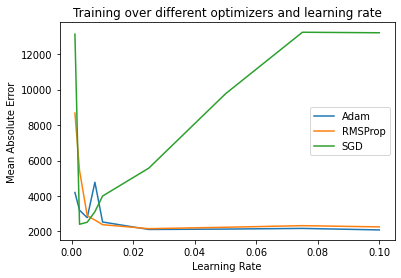

In [155]:
plt.plot(result_report['Learning Rate'], result_report['Adam-Avg'], label='Adam')
plt.plot(result_report['Learning Rate'], result_report['RMSprop-Avg'], label='RMSProp')
plt.plot(result_report['Learning Rate'], result_report['SGD-Avg'], label='SGD')

plt.title('Training over different optimizers and learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Absolute Error')
plt.legend();

Small learning rate gives better result.

Best parameter -> Adam optimizer with learning rate 0.025

### Regularization & Drop Out

<b>Regularizers</b> allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

<b>Dropout</b> is one of the most effective and most commonly used regularization techniques for neural networks. The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

We can combined both of them to avoid overfitting.


In [0]:
regularizer_rates = [0, .001, .01, .1]
dropout_rates = [0, .2, .35, .5]

In [161]:
drp_log, reg_log, mae_log ,mse_log = [], [], [], []

for i, (train_features, train_target, 
        validation_features, validation_target) in enumerate(train_val_split):
  
    for dropout_rate in dropout_rates:
        print('dropout_rate: {:.2f}'.format(dropout_rate))
        for regularizer_rate in regularizer_rates:
            print('     regularizer_rate: {:.2f}'.format(regularizer_rate))
            mlp = multilayer_perceptron(train_features.shape[1], .025, 'adam', regularizer_rate, dropout_rate)
            model, history = train_model(mlp, train_features, train_target, N_epoch)
            loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
            drp_log.append(dropout_rate)
            reg_log.append(regularizer_rate)
            mae_log.append(mae)
            mse_log.append(mse)
        print("")

    print('    Done for group-{:d}'.format(i+1))


dropout_rate: 0.00
     regularizer_rate: 0.00
7/7 [==============================] - 0s 1ms/step - loss: 2441.6497 - mae: 2241.0486 - mse: 30383838.0000
     regularizer_rate: 0.00
7/7 [==============================] - 0s 2ms/step - loss: 2338.7234 - mae: 2164.6750 - mse: 28622438.0000
     regularizer_rate: 0.01
7/7 [==============================] - 0s 2ms/step - loss: 2130.9846 - mae: 1923.4298 - mse: 28348622.0000
     regularizer_rate: 0.10
7/7 [==============================] - 0s 2ms/step - loss: 2873.9028 - mae: 2397.3435 - mse: 30763468.0000

dropout_rate: 0.20
     regularizer_rate: 0.00
7/7 [==============================] - 0s 2ms/step - loss: 2595.8479 - mae: 2401.6494 - mse: 30566896.0000
     regularizer_rate: 0.00
7/7 [==============================] - 0s 2ms/step - loss: 2610.5139 - mae: 2392.8730 - mse: 31025570.0000
     regularizer_rate: 0.01
7/7 [==============================] - 0s 2ms/step - loss: 2811.2974 - mae: 2496.2275 - mse: 31553416.0000
     regularizer

In [171]:
grp_2d = [["Group-{:d}".format(i+1)]*16 for i in range(n_splits)]
grp = [g for grp1 in grp_2d for g in grp1]
len(grp)

80

In [172]:
drp_reg_result = pd.DataFrame({"Group": grp, "Drop-out rate": drp_log, "Regularizer rate": reg_log,
                               "Mean Absolute Error": mae_log, "Mean Squared Error": mse_log})
drp_reg_result

,Group,Drop-out rate,Regularizer rate,Mean Absolute Error,Mean Squared Error
0,Group-1,0.00,0.000,2241.048584,30383838.0
1,Group-1,0.00,0.001,2164.675049,28622438.0
2,Group-1,0.00,0.010,1923.429810,28348622.0
3,Group-1,0.00,0.100,2397.343506,30763468.0
4,Group-1,0.20,0.000,2401.649414,30566896.0
...,...,...,...,...,...
75,Group-5,0.35,0.100,2192.464844,23315350.0
76,Group-5,0.50,0.000,2243.141113,23981716.0
77,Group-5,0.50,0.001,2245.438965,25831792.0
78,Group-5,0.50,0.010,2316.252930,25073128.0


In [173]:
drp_reg_result.to_excel('hyper tuning parameter regularization and drop-out.xlsx', index=False)
print('Saved process done.')

Saved process done.


In [174]:
grp_result = drp_reg_result.groupby(['Drop-out rate', 'Regularizer rate'])[['Mean Absolute Error', 'Mean Squared Error']].mean()
grp_result

Mean Absolute Error  Mean Squared Error
Drop-out rate Regularizer rate                                         
0.00          0.000                     2107.611011          25549330.4
              0.001                     1822.252344          23304376.8
              0.010                     1715.244385          23085963.6
              0.100                     2149.403687          25114204.8
0.20          0.000                     2293.447534          26364423.6
              0.001                     2287.452441          26255062.8
              0.010                     2300.825244          26016551.6
              0.100                     2445.246777          26762086.8
0.35          0.000                     2407.247314          26742200.4
              0.001                     2333.242871          26191801.2
              0.010                     2335.385059          26238542.0
              0.100                     2453.067822          27437184.0
0.50          0.000                     2577.358691          28967509.6
              0.001                     2486.757275          28077121.6
              0.010                     2527.364111          28542016.0
              0.100                     2639.293457          28440641.6

Refer to previous experiment, the better result comes with drop-out rate = 0 and regularizer rate = 0.01 (mae), 0.1 (mse)

### Evaluate with test set

After work on hyper tuning parameter, we can apply the best parameter to test set. And see whether a overfitting issue or not

In [176]:
mae_log ,mse_log = [], []

for train_features, train_target, validation_features, validation_target in train_val_split:

    mlp = multilayer_perceptron(train_features.shape[1], .025, 'adam', 0.01, 0)
    model, history = train_model(mlp, train_features, train_target, N_epoch)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
    mae_log.append(mae)
    mse_log.append(mse)

7/7 [==============================] - 0s 2ms/step - loss: 1718.6458 - mae: 1530.6906 - mse: 20062406.0000


In [179]:
grp_log = ['Group-'+str(i+1) for i in range(n_splits)]
log = pd.DataFrame({"Group": grp_log, "Mean Absolute Error": mae_log, "Mean Squared Error": mse_log})
print('Test result with validation set that obtained from train-validation-test split using Sorted Stratified K Fold Cross Validation')
log

Test result with validation set that obtained from train-validation-test split using Sorted Stratified K Fold Cross Validation


,Group,Mean Absolute Error,Mean Squared Error
0,Group-1,1753.206543,27742098.0
1,Group-2,1763.715942,25310854.0
2,Group-3,1405.557129,16371304.0
3,Group-4,2170.258789,25846686.0
4,Group-5,1530.690552,20062406.0


In [180]:

print("Minimum MAE =  ",log["Mean Absolute Error"].min())
print("Maximum MAE =  ",log["Mean Absolute Error"].max())
print("Average MAE =  ",log["Mean Absolute Error"].mean())

Minimum MAE =   1405.55712890625
Maximum MAE =   2170.2587890625
Average MAE =   1724.685791015625


Right now, we know that our model can get result with 'Mean Absolute Error' between 1416,74 and 1540,08. Now lets check with test set. (N_epoch=4000)

> If you run the cell many times you can get different result. But the interval of MAE will not be much different

In [181]:
test_target = target[normed_test_features.index]
loss, mae, mse = model.evaluate(normed_test_features, test_target)

print("MAE for testing set =  {:5.2f} (charges)".format(mae))

9/9 [==============================] - 0s 1ms/step - loss: 1687.9614 - mae: 1563.4626 - mse: 18696028.0000
MAE for testing set =  1563.46 (charges)


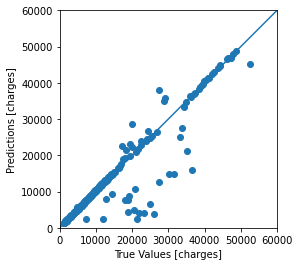

In [182]:
test_predictions = model.predict(normed_test_features).flatten()

a = plt.axes(aspect='equal')

plt.scatter(test_target, test_predictions)

plt.xlabel('True Values [charges]')
plt.ylabel('Predictions [charges]')
lims = [0, 6e4]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

For this testing we get MAE of 1639,38.


If we compare with result that we obtained from validation set, our model can predict data with MAE 1487,84. We get <b>difference of 151,54 from model validation</b>. That is good result <b>(not overfitting)</b>.

# Results and Conclusion

In [183]:
dataset['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

We have performed regression analysis model to predict health insurance cost should be paid for given features. We have shown in the above, several results related to our MAE for test data. We think from the range of `charges` category in the datasets, our predicted health insurance won't sufficiently good for person who has medical bill around 1000.

As we plot the joint distribution, we can see at glance that there are so much irregularity to the data. If we look closely to some elements in that joint distrbution, there are some clusters related to BMI and charges. It can be inferred another model like clustering can make a group for a range of health insurance bill. This will be another project.

